In [213]:
#Step 1 Data Preprocessing

C:\Users\USER\AppData\Local\Temp\ipykernel_13092\2323755385.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  links_df["tmdbId"].fillna(-1, inplace=True)


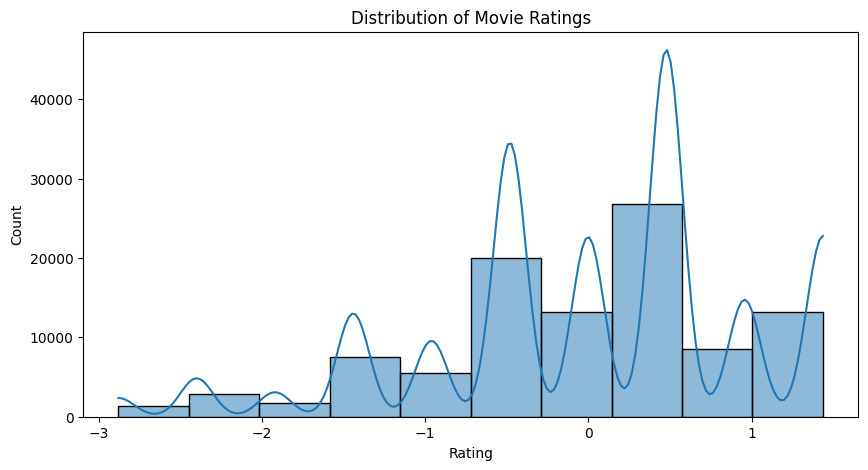

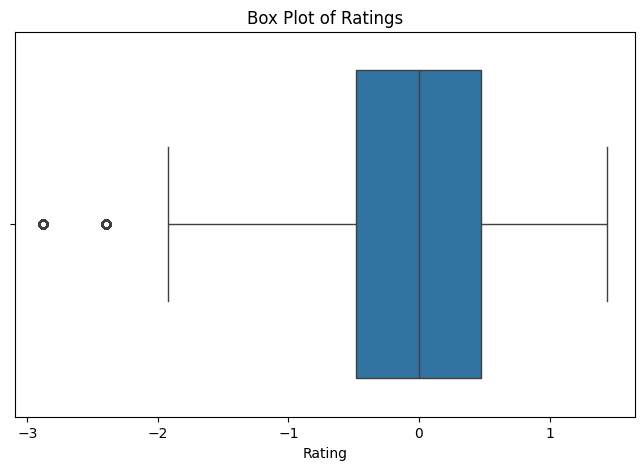

C:\Users\USER\AppData\Local\Temp\ipykernel_13092\2323755385.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


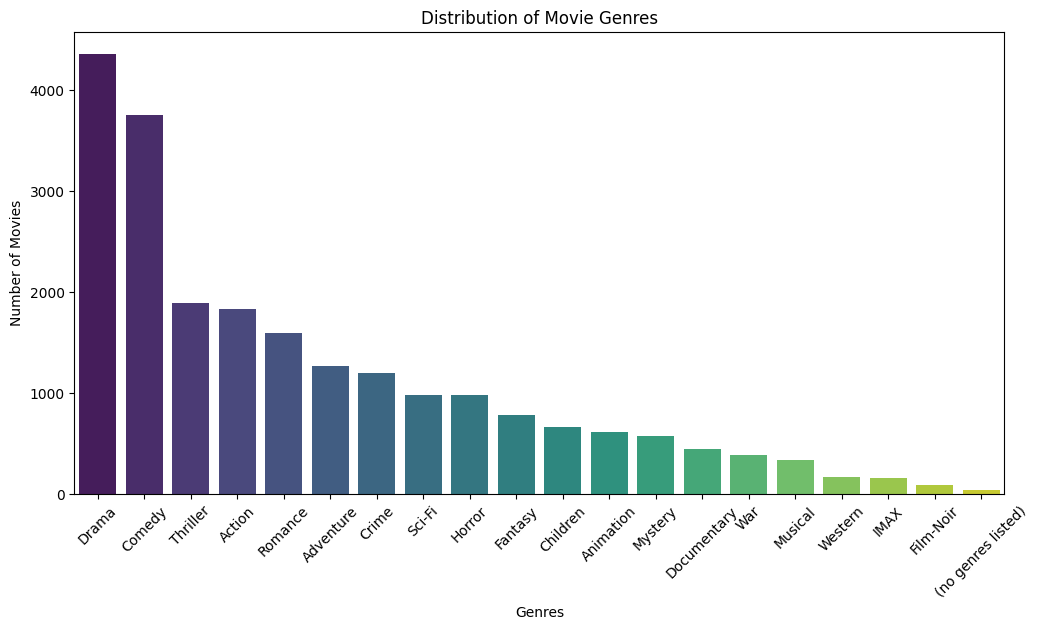

Processed Ratings Dataset:
   userId  movieId    rating
0       1        1  0.478112
1       1        3  0.478112
2       1        6  0.478112
3       1       47  1.437322
4       1       50  1.437322
Processed Movies Dataset:
   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                 NaN     NaN   
1        2                      Jumanji (1995)                 0.0     0.0   
2        3             Grumpier Old Men (1995)                 0.0     0.0   
3        4            Waiting to Exhale (1995)                 0.0     0.0   
4        5  Father of the Bride Part II (1995)                 0.0     0.0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  \
0        NaN        NaN       NaN     NaN    NaN          NaN  ...        NaN   
1        1.0        1.0       1.0     1.0    0.0          0.0  ...        0.0   
2        1.0        0.0       1.0     0.0    0.0          0.0

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

# Load MovieLens 100K dataset
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'
links_path = 'links.csv'

# Load datasets
ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)
links_df = pd.read_csv(links_path)

# 1. Handle Missing Values
links_df["tmdbId"].fillna(-1, inplace=True)

# 2. Remove Unnecessary Columns
ratings_df.drop(columns=["timestamp"], inplace=True)
tags_df.drop(columns=["timestamp"], inplace=True)

# 3. Optimize Data Types
ratings_df = ratings_df.astype({"userId": "int32", "movieId": "int32", "rating": "float32"})
links_df = links_df.astype({"movieId": "int32", "imdbId": "int32", "tmdbId": "int32"})

# 4. Process Genres (Sparse Encoding for Efficiency)
movies_df["genres"] = movies_df["genres"].str.split("|")
genres_exploded = movies_df.explode("genres")
genres_one_hot = pd.get_dummies(genres_exploded["genres"], dtype=np.uint8)
movies_df_encoded = movies_df.drop(columns=["genres"]).join(
    genres_one_hot.groupby(movies_df["movieId"]).max()
)


# 5. Normalize Rating Data
scaler = StandardScaler()
ratings_df["rating"] = scaler.fit_transform(ratings_df[["rating"]])

# 6. Merge Ratings with Movies for Further Analysis
ratings_with_genres = ratings_df.merge(movies_df_encoded, on="movieId", how="left")

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.histplot(ratings_df["rating"], bins=10, kde=True)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Movie Ratings")
plt.show()

# Box Plot of Ratings
plt.figure(figsize=(8, 5))
sns.boxplot(x=ratings_df["rating"])
plt.xlabel("Rating")
plt.title("Box Plot of Ratings")
plt.show()

# Genre Distribution
genre_counts = genres_exploded["genres"].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Genres")
plt.show()

# Display Processed Data
print("Processed Ratings Dataset:")
print(ratings_df.head())
print("Processed Movies Dataset:")
print(movies_df_encoded.head())


Optimized K-Means Silhouette Score: 0.16897905465223964
Optimized K-Means Davies-Bouldin Index: 2.0973506144496326
Optimized K-Means Calinski-Harabasz Index: 7335.405891637841


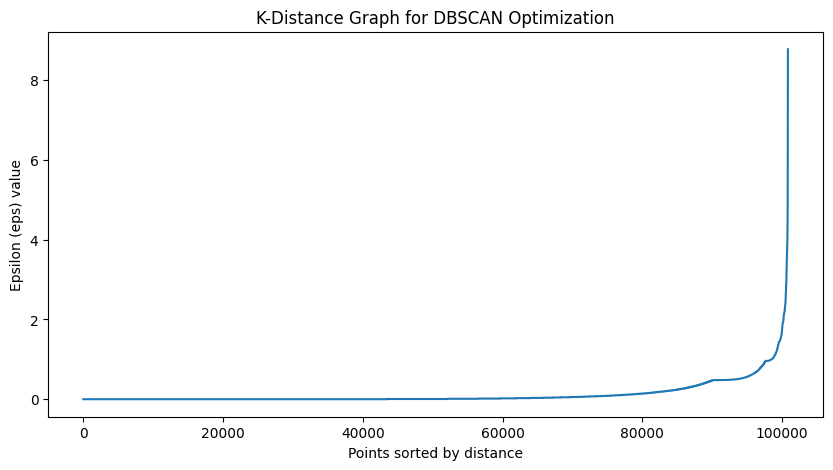

Optimized DBSCAN Silhouette Score: 0.35036404167241453
Optimized DBSCAN Davies-Bouldin Index: 1.2840723767962963
Optimized DBSCAN Calinski-Harabasz Index: 909.4826075317499


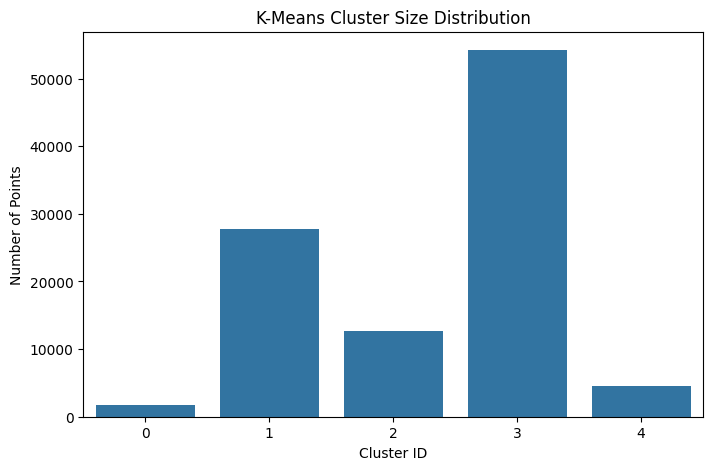

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score



features = ratings_with_genres.drop(columns=["movieId", "title"], errors='ignore').fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# # 7. Finding the Best K for K-Means and ckecking cluster distributions.
# inertia = []
# silhouette_scores = []
# K_range = range(2, 11)
# best_k = None
# best_silhouette = -1
# cluster_distributions = {}

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(features_scaled)
#     inertia.append(kmeans.inertia_)
#     sil_score = silhouette_score(features_scaled, labels)
#     silhouette_scores.append(sil_score)
    
#      # Store cluster distributions
#     cluster_counts = pd.Series(labels).value_counts().sort_index()
#     cluster_distributions[k] = cluster_counts

#     if sil_score > best_silhouette:
#         best_silhouette = sil_score
#         best_k = k

# # Print the best K value and corresponding silhouette score
# print(f"Best K: {best_k} with Silhouette Score: {best_silhouette}")

# # Print Cluster Distributions for Each K
# for k, counts in cluster_distributions.items():
#     print(f"\nCluster distribution for K={k}:")
#     print(counts)

# # # Plot cluster distributions for each K
# fig, axes = plt.subplots(len(K_range), 1, figsize=(8, 4 * len(K_range)))


# for idx, k in enumerate(K_range):
#     axes[idx].bar(cluster_distributions[k].index, cluster_distributions[k].values, color='blue')
#     axes[idx].set_xlabel("Cluster ID")
#     axes[idx].set_ylabel("Number of Movies")
#     axes[idx].set_title(f"Cluster Size Distribution for K={k}")

# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(K_range, inertia, marker='o')
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Inertia")
# plt.title("Elbow Method for Optimal K")
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(K_range, silhouette_scores, marker='o', color='red')
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Score for Different K Values")
# plt.show()

#based on the above best_k for clustering distributuion is 5 so we go with that, best sillouete score wasm for k=2 but it had 1 huge cluster.
#The best clustering was for k=4, k=5, we choose 5 because it added a cluster bigger than the first one

best_k=5 
# 8. Apply K-Means with Best K
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# 9. Evaluate Optimized K-Means
silhouette_kmeans = silhouette_score(features_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(features_scaled, kmeans_labels)
ch_kmeans = calinski_harabasz_score(features_scaled, kmeans_labels)

print(f"Optimized K-Means Silhouette Score: {silhouette_kmeans}")
print(f"Optimized K-Means Davies-Bouldin Index: {davies_bouldin_kmeans}")
print(f"Optimized K-Means Calinski-Harabasz Index: {ch_kmeans}")

# 10. Optimize DBSCAN using K-Distance Graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("Epsilon (eps) value")
plt.title("K-Distance Graph for DBSCAN Optimization")
plt.show()

# 11. Apply Optimized DBSCAN
dbscan_opt = DBSCAN(eps=0.6, min_samples=4)
dbscan_labels_opt = dbscan_opt.fit_predict(features_scaled)

# 12. Evaluate Optimized DBSCAN
silhouette_dbscan_opt = silhouette_score(features_scaled, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
davies_bouldin_dbscan_opt = davies_bouldin_score(features_scaled, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
ch_dbscan_opt = calinski_harabasz_score(features_scaled, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None

print(f"Optimized DBSCAN Silhouette Score: {silhouette_dbscan_opt}")
print(f"Optimized DBSCAN Davies-Bouldin Index: {davies_bouldin_dbscan_opt}")
print(f"Optimized DBSCAN Calinski-Harabasz Index: {ch_dbscan_opt}")

# 13. Plot Cluster Size Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=kmeans.labels_)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")
plt.title("K-Means Cluster Size Distribution")
plt.show()